# Convert Karkoschka I/F --> Flux Radiance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

In [2]:
coulter_barnes_fortney= np.genfromtxt('./../jupiter_spectra/coulterbarnesfortney_fig4_jup.txt') # Cassini Visual and Infrared Mapping Spectrometer (VIMS) (spectra was converted to disk integrated)
madden= np.genfromtxt('../madden_spectra/CatalogofSolarSystemObjects/Albedos/Jupiter_Lundock080507_Albedo.txt') # Disk Integrated
default_psg= np.genfromtxt('../jupiter_spectra/psg_rad_5micron_jupdefault.txt')
original_molecules= np.genfromtxt('../vary_params/original_molecules.csv')
day_night_jup= np.genfromtxt('../jupiter_spectra/coulterbarnesfortney_fig5_jup_dbf5.txt')
karkoschka_fromgv= np.genfromtxt('../jupiter_spectra/KarkoschkaAlbedoJupiter.txt')
# The data for each of the spectral data types (day/night, cloudy/clear) come from day_night_jup. need to sort:
dayside_cloudy= np.array(day_night_jup[0:330])
dayside_clear= np.array(day_night_jup[331:330*2])
nightside_cloudy= np.array(day_night_jup[661:330*3])
nightside_clear= np.array(day_night_jup[990:330*4])

In [3]:
# seperating the values to only include those at phase angle=0
phase_zero_wavelength=[]
phase_zero_albedo=[]
phase_zero_flux=[]
for row in coulter_barnes_fortney:
    if row[0]<2:
        #print(row[1])
        #row[1], row[3])
        phase_zero_wavelength.append(row[1])
        phase_zero_albedo.append(row[3])
        phase_zero_flux.append(row[2])

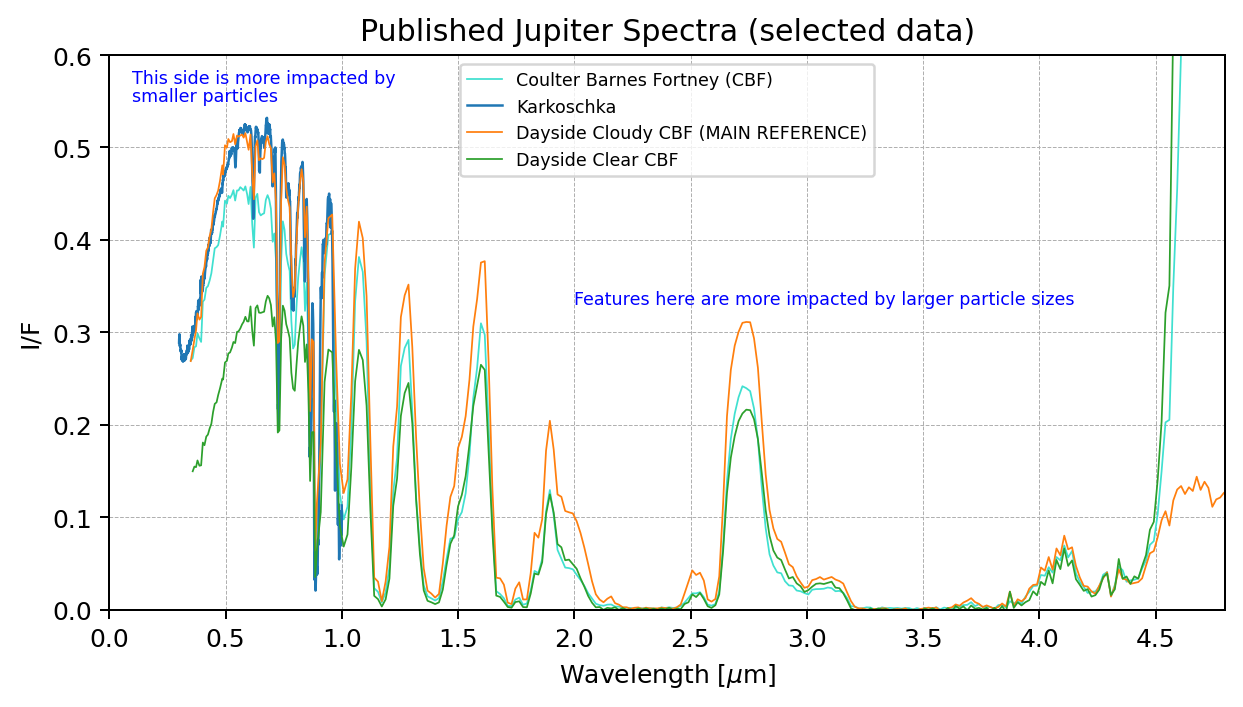

In [4]:
plt.figure(figsize=(8,4), dpi=180)
plt.plot(phase_zero_wavelength, phase_zero_albedo, label='Coulter Barnes Fortney (CBF)', color='turquoise', linewidth=0.7)
plt.plot((karkoschka_fromgv[:,0])/1000, karkoschka_fromgv[:,3], label='Karkoschka', linewidth=1)
plt.plot(dayside_cloudy[:,1],dayside_cloudy[:,3], label='Dayside Cloudy CBF (MAIN REFERENCE)', linewidth=0.7)
plt.plot(dayside_clear[:,1],dayside_clear[:,3], label='Dayside Clear CBF', linewidth=0.7)
plt.grid()
plt.ylim(0,0.6)
plt.xlim(0,4.8)
plt.title('Published Jupiter Spectra (selected data)')
plt.xlabel(r'Wavelength [$\mu$m]')
plt.ylabel('I/F')
plt.xticks(np.arange(0,4.8, 0.5))
plt.grid(True, linewidth=0.4, linestyle='--') 
plt.legend(fontsize=7)
#plt.savefig('FocusedJupiterSpectra.png');
plt.text(2, 0.33, 'Features here are more impacted by larger particle sizes', fontsize=7, color='blue')
plt.text(0.1, 0.57, 'This side is more impacted by', fontsize=7, color='blue')
plt.text(0.1, 0.55, 'smaller particles', fontsize=7, color='blue');

# calculate size of sun in steradians at dist of jupiter

In [5]:
def star_sr_pl(Rstar,d_pl):
    d_pl *=  1.496e8 # km/AU
    """
    input: rstar in kilometers, d_pl in AU
    Returns the size of the star in the sky in steradians at the distance of the planet from the star
    """
    return np.pi*(np.rad2deg(np.tan(2*Rstar/d_pl))/2)**2* ((np.pi/180)**2)

# compute black body curve for the sun in units of W/m2/um/sr

In [6]:
def black_body_rad(T, u):
    h   = 6.62607015e-34     # Planck's constant (J s)
    Na  = 6.02214076e23      # Avogadro's number (mol-1)
    kb  = 1.380649e-23       # Boltzmann constant (J/K)
    c   = 299792458.0        # Speed of light (m/s)
    amu = 1.660539040e-27    # Atomic mass unit (kg)
    G   = 6.67430e-11        # Gravitational constant (m3⋅kg−1⋅s−2)
    c2  = h*c/kb
    """
    Return black body emission from body at temperature T at wavelength u in meters
    Units are in W/m2/um/sr
    """
    B = 2*h*c**2/(u**5)/(np.exp(c2/(u*T))-1)/1e6
    return B

In [8]:
# Wavelength range (in meters), for example, from 0.1 to 10 micrometers
wavelength_range = np.linspace(.3e-6, 5e-6, 330)

# Calculate blackbody radiation spectrum for the Sun
solar_spectrum = black_body_rad(5778, wavelength_range)

In [42]:
vals_mult= []
for value in phase_zero_flux:
    new_val= value* 1e4
    vals_mult.append(new_val)
new_wavelength_m=[]
for value in wavelength_range:
    new_val= value*1e6
    new_wavelength_m.append(new_val)

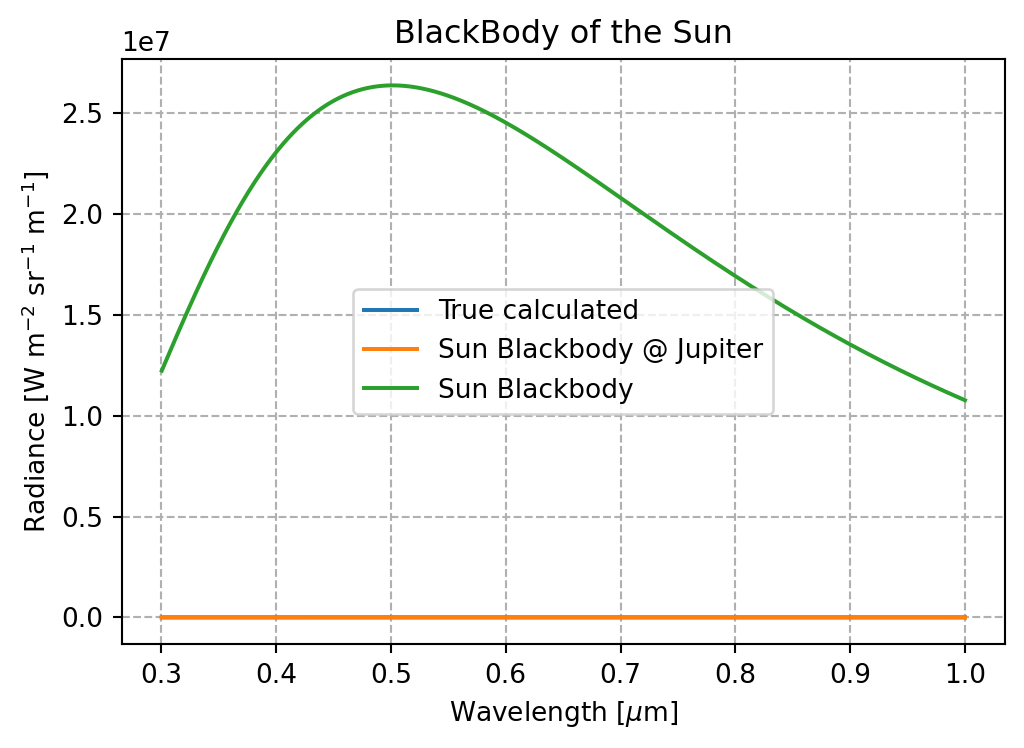

In [53]:
plt.figure(figsize=(6,4), dpi=190)
plt.plot(karkoschka_fromgv[:,0]/1000,(((karkoschka_fromgv[:,3]*jupiter_karkoschka_reflected_denominator)/2500)*1e2), label='True calculated')
plt.plot(karkoschka_fromgv[:,0]/1000,jupiter_reflect(solar_spectrum_karkoscka_range, 5.2), label= 'Sun Blackbody @ Jupiter')
plt.plot(karkoschka_fromgv[:,0]/1000,solar_spectrum_karkoscka_range, label= 'Sun Blackbody')
#plt.plot(new_wavelength_m,solar_spectrum/sr_sun)
plt.ylabel('Radiance [W m$^{-2}$ sr$^{-1}$ m$^{-1}$]')
plt.xlabel('Wavelength [$\mu$m]')
plt.grid(linestyle='--')
plt.title('BlackBody of the Sun')
plt.legend();

In [50]:
def jupiter_reflect(incident_light, d_pl):
    d_pl *=  1.496e8 # km/AU
    #print(d_pl)
    reflected_light = incident_light / (4 * np.pi * d_pl**2)   
    return reflected_light

# *Recent* Conversion Attempt

In [19]:
# Calculate the sun black body in the wavelength range of Karkoschka
# Divide x values by 1e9 to convert from nanometers to meters
solar_spectrum_karkoscka_range = black_body_rad(5778, (karkoschka_fromgv[:,0]/1e9))
# Scale the solar_spectrum to get the flux recieved at the distance of jupiter (scales by 1/5.2^2)
jupiter_karkoschka_reflected_denominator= jupiter_reflect(solar_spectrum_karkoscka_range, 5.2)

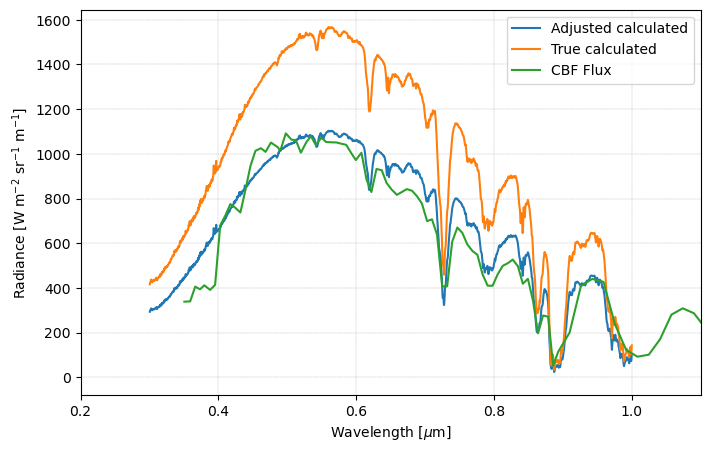

In [59]:
plt.figure(figsize=(8,5))
plt.plot(karkoschka_fromgv[:,0]/1000,(((karkoschka_fromgv[:,3]*jupiter_karkoschka_reflected_denominator)/3550)*1e2), label='Adjusted calculated')
plt.plot(karkoschka_fromgv[:,0]/1000,(((karkoschka_fromgv[:,3]*jupiter_karkoschka_reflected_denominator)/2500)*1e2), label='True calculated')
plt.plot(phase_zero_wavelength,phase_zero_flux, label='CBF Flux')
plt.xlim(0.2,1.1)
plt.legend()
plt.grid(linestyle='--', linewidth=0.3)
plt.ylabel('Radiance [W m$^{-2}$ sr$^{-1}$ m$^{-1}$]')
plt.xlabel('Wavelength [$\mu$m]');